In [55]:
import copy

import cv2
import matplotlib.pyplot as plt
import numpy as np

## 画像表示

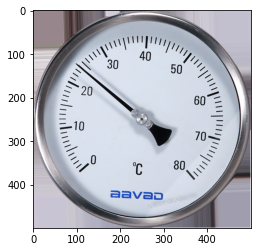

In [114]:
img = cv2.imread('./images/meter4.png')
plt.imshow(img[:, :, ::-1])
plt.show()

## センサーの半径とその中心を取得

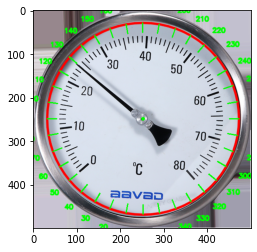

In [115]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r


img_to_write = copy.deepcopy(img)

height, width = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 中心と半径をハフ変換にて取得
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.5))
x, y, r = avg_circles(circles, circles.shape[1])
cv2.circle(img_to_write, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)
cv2.circle(img_to_write, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)

# 角度を10度刻みで描画
separation = 10.0
interval = int(360 / separation)
text_offset_x = 10
text_offset_y = 5
p1 = np.zeros((interval, 2))
p2 = np.zeros((interval, 2))
p_text = np.zeros((interval,2))
for i in range(0, interval):
    for j in range(0, 2):
        point_angle = separation * i * 3.14 / 180
        text_point_angle = separation * (i + 9) * 3.14 / 180
        if (j % 2 == 0):
            p1[i][j] = x + 0.9 * r * np.cos(point_angle)
            p2[i][j] = x + r * np.cos(point_angle)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos(text_point_angle)
        else:
            p1[i][j] = y + 0.9 * r * np.sin(point_angle)
            p2[i][j] = y + r * np.sin(point_angle)
            p_text[i][j] = y + text_offset_y + 1.2 * r * np.sin(text_point_angle)
for i in range(0, interval):
    cv2.line(
        img_to_write,
        (int(p1[i][0]), int(p1[i][1])),
        (int(p2[i][0]), int(p2[i][1])),
        (0, 255, 0),
        2
    )
    cv2.putText(
        img_to_write,
        f'{int(i * separation)}',
        (int(p_text[i][0]), int(p_text[i][1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
        cv2.LINE_AA
    )
plt.imshow(img_to_write[:, :, ::-1])
plt.show()

## メータの始まりと終わりの角度を自動で取得

### 必要な領域だけ取得

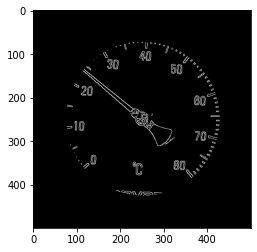

In [116]:
def get_meter_region(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img


vertices = np.zeros((interval, 2))
for i in range(0, interval):
    for j in range(0, 2):
        vertices[i][j] = x + 0.8 * r * np.cos(separation * i * np.pi / 180) if j % 2 == 0 \
            else y + 0.8 * r * np.sin(separation * i * np.pi / 180)
canny = cv2.Canny(gray, 200, 20)
cropped_img = get_meter_region(canny, np.array([vertices], np.int32))
plt.imshow(cropped_img, cmap='gray')
plt.show()

### 輪郭抽出

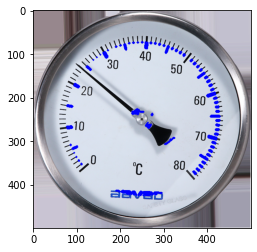

In [117]:
img_to_write = copy.deepcopy(img)
contours, _ = cv2.findContours(cropped_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
target_cnt_list = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < 15:
        cv2.drawContours(img_to_write, contour, -1, (255, 0, 0), 3)
        target_cnt_list.append(contour)
plt.imshow(img_to_write[:, :, ::-1], cmap='gray')
plt.show()

### 輪郭から角度の最小値と最大値取得

In [118]:
reference_start_angle = 35
reference_end_angle = 330
min_angle = 90
max_angle = 270

for i in range(len(target_cnt_list)):
    cnt = target_cnt_list[i]
    cnt = cnt.reshape(len(cnt), 2)
    x1, y1 = np.mean(cnt, axis=0)
    x_len = x1 - x
    y_len = y - y1
    res = np.arctan(np.divide(float(abs(y_len)), float(abs(x_len))))
    res = np.rad2deg(res)
    if x_len < 0 and y_len < 0:
        start_angle = 90 - res
        if start_angle > reference_start_angle:
            if start_angle < min_angle:
                min_angle = start_angle
    elif x_len > 0 and y_len < 0:
        end_angle = 270 + res
        if end_angle < reference_end_angle:
            if end_angle > max_angle:
                max_angle = end_angle
print('角度最小値:', min_angle)
print('角度最小値:', max_angle)

角度最小値: 53.67937170376982
角度最小値: 326.4065525839725


## 針の角度取得

手順は、以下の通り
1. 画像をグレースケール化
2. 2値化
3. ハフ変換で直線取得
4. メータの中心軸からのx, yそれぞれの座標間距離を求める(それぞれ、x_diff, y_diffとする)
5. 手順4で求めた距離の`arctan(y_diff/x_diff)` を求める

### 直線検出

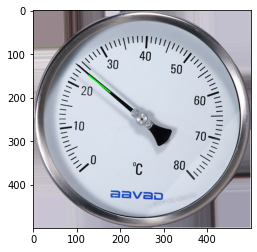

In [119]:
def dist_2_pts(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


# 画像のグレースケール化
img_to_write = copy.deepcopy(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, gray = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
lines = cv2.HoughLinesP(image=gray, rho=3, theta=np.pi / 180, threshold=100, minLineLength=10, maxLineGap=0)

diff1_lower_bound = 0.15
diff1_upper_bound = 0.5
diff2_lower_bound = 0.5
diff2_upper_bound = 1.0
final_line_list = []
for i in range(len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        diff1 = dist_2_pts(x, y, x1, y1)
        diff2 = dist_2_pts(x, y, x2, y2)
        if (diff1 > diff2):
            diff1, diff2 = diff2, diff1
        if ((diff1 < diff1_upper_bound * r) and (diff1 > diff1_lower_bound * r) and (diff2 < diff2_upper_bound * r) and (diff2 > diff2_lower_bound * r)):
            final_line_list.append([x1, y1, x2, y2])

x1 = final_line_list[0][0]
y1 = final_line_list[0][1]
x2 = final_line_list[0][2]
y2 = final_line_list[0][3]
cv2.line(img_to_write, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img_to_write[:, :, ::-1])
plt.show()


### 角度計算

In [120]:
# 0度からの角度計算
dist_pt_0 = dist_2_pts(x, y, x1, y1)
dist_pt_1 = dist_2_pts(x, y, x2, y2)
if (dist_pt_0 > dist_pt_1):
    x_for_angle = x1 - x
    y_for_angle = y - y1
else:
    x_for_angle = x2 - x
    y_for_angle = y - y2

print(dist_pt_0, dist_pt_1, x_for_angle, y_for_angle, x, y)
    
res = np.arctan(np.divide(float(y_for_angle), float(x_for_angle)))
res = np.rad2deg(res)
if x_for_angle > 0 and y_for_angle > 0:
    final_angle = 270 - res
if x_for_angle < 0 and y_for_angle > 0:
    final_angle = 90 - res
if x_for_angle < 0 and y_for_angle < 0:
    final_angle = 90 - res
if x_for_angle > 0 and y_for_angle < 0:
    final_angle = 270 - res
print('0度からの角度: ', final_angle)

160.0781059358212 97.45255255764212 -125 100 252 249
0度からの角度:  128.65980825409008


## メータの値取得

In [124]:
# メータ上の開始位置と終了位置の角度を指定
min_angle = 50
max_angle = 320

# メータの読みの最小値と最大値を指定
min_value = 0
max_value = 80

old_min = float(min_angle)
old_max = float(max_angle)

new_min = float(min_value)
new_max = float(max_value)

old_value = final_angle

old_range = (old_max - old_min)
new_range = (new_max - new_min)
new_value = (((old_value - old_min) * new_range) / old_range) + new_min
print(f"Reading of the Gauge is {new_value}")

Reading of the Gauge is 23.306609853063726


In [53]:
from analog_meter_reader.needle.angle import angle2meter_value

In [54]:
angle2meter_value(final_angle, min_angle, max_angle, min_value, max_value)

23.30660985306373